May: Bathymetry of Mackenzie Canyon as depicted by the IBCAO_V3_500m_RR and IBCAO_V3_30arcsec_RR.

IBCAO_V3_500m_RR

* title: J:\jazz3\IBCAO_ASCII_INPUTDATA\ver3.0\\resamp_grd01.grd
* GMT_version: 4.5.8
* dimensions(sizes): x(11617), y(11617)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
 

* float64 x(x), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float64 y(y), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float32 z(y, x), actual_range: [-5573.01660156  5921.39746094], current shape = (11617, 11617)
* polar stereographic projection

IBCAO_V3_30arcsec_RR

* title: IBCAO_V3_30arcsec_RR.grd
* GMT_version: 4.5.8 [64-bit]
* dimensions(sizes): x(43201), y(3121)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
* "Geographic Coordinate System"

In [1]:
import  numpy as np
import  os
import  scipy as sc, scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from    pyproj import Proj, Geod
import math
import  cartopy.crs as ccrs
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_variables(ibcao_grid_name):
    ibcao_grid_dir = '/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid'
    ibcao_grid = os.path.join(ibcao_grid_dir, ibcao_grid_name)
    ibcao_nc = scipy.io.netcdf_file (ibcao_grid)

    x = ibcao_nc.variables['x'][:]
    y = ibcao_nc.variables['y'][:]
    z = ibcao_nc.variables['z'][:]
    return x, y, z

In [3]:
x, y, z = get_variables('IBCAO_V3_500m_RR.grd')

In [4]:
def Colormap():
    COLORMAP = """\
    # downloaded from IBCAO homepage
    #Discrete color table for Ocean and continous for land in RGB for the Arctic bathymetry and topography
    -6000	18	10	59	-5000	18	10	59
    -5000	22	44	103	-4000	22	44	103
    -4000	22	88	135	-3000	22	88	135
    -3000	22	138	170	-2000	22	138	170
    -2000	22	154	184	-1500	22	154	184
    -1500	23	170	198	-1000	23	170	198
    -1000	23	186	212	-500	23	186	212
    -500	24	196	223	-250	24	196	223
    -250	25	206	234	-100	25	206	234
    -100	27	216	245	-75	27	216	245
    -75	38	223	241	-50	38	223	241
    -50	49	230	236	-25	49	230	236
    -25	105	242	233	-10	105	242	233
    -10	161	255	230	0	161	255	230
    0	40	158	38	25	44	176	42
    25	44	176	42	50	49	195	46
    50	49	195	46	75	145	208	80
    75	145	208	80	100	242	202	90
    100	242	202	90	200	227	170	48
    200	227	170	48	300	190	140	40
    300	190	140	40	400	151	109	31
    400	151	109	31	500	114	80	23
    500	114	80	23	600	95	63	12
    600	95	63	12	700	81	57	16
    700	81	57	16	800	114	97	71
    800	114	97	71	1000	105	105	105
    1000	105	105	105	1500	170	170	170
    1500	170	170	170	5000	200	200	200
    """
    cmap = np.empty ((0,4))
    c = 0
    for l in COLORMAP.split("\n"):
      l = l.strip()
      if len(l) == 0 or l[0] == '#':
        continue
      ls = np.array([float (v) for v in l.split ()])
      if ls.shape[0] < 8:
        continue
      c += 1
      cmap.resize (c, 4)
      cmap[c-1,:] = ls[:4]
    c += 1
    cmap.resize (c, 4)
    cmap[c-1,:] = ls[4:]
    cmap[:,[1, 2, 3]] = cmap[:,[1, 2, 3]] / 255.
    cmap_out = cm.colors.ListedColormap (cmap[:,1:4], 'ibcao', c)
    norm     = cm.colors.BoundaryNorm (cmap[:,0], c)
    return (cmap_out, norm)

def get_cartopyS():
    m = ccrs.Stereographic(central_latitude=90, central_longitude=0, false_easting=0, false_northing=0, 
                           true_scale_latitude=75.0)
    return m

def get_cartopyG():
    # http://scitools.org.uk/cartopy/docs/v0.13/crs/projections.html ---- projections list
    m = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    return m

In [5]:
def return_boundariesS(x, y, z, xl, xr, yb, yt, case):
    '''Extracts region from full bathymetry file.
    Stereographic projection IBCAO_V3_500m_RR.
    '''
    if case == 'region':
        xl=-1800000; xr=-700000; yb=1200000; yt=2000000
    elif case == 'canyon':
        xl=-1600000; xr=-1350000; yb=1560000; yt=1730000
    elif case == 'HS':
        xl=-1630000; xr=-1470000; yb=1580000; yt=1710000
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(x==xl)[0][0]
    xmax = np.where(x==xr)[0][0]
    ymin = np.where(y==yb)[0][0]
    ymax = np.where(y==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

def return_boundariesG(x, y, z, xl, xr, yb, yt, case):
    '''Extracts region from full bathymetry file.
    Geographic projection IBCAO_V3_30arcsec_RR.
    '''
    if case == 'region':
        xl=-145; xr=-133; yb=68.6; yt=72.5
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(np.round(x,2)==xl)[0][0]
    xmax = np.where(np.round(x,2)==xr)[0][0]
    ymin = np.where(np.round(y,2)==yb)[0][0]
    ymax = np.where(np.round(y,2)==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

def plot_mackenzie(fig, ax, xn, yn, zn, plot_type, lines):
    '''Plots canyon bathymetry using xn, yn, and zn
    for region specified in the return_boundaries function.
    '''
    #(cmap, norm) = Colormap()
    cmap = cm.gist_earth
    if plot_type == 'full':
        c = ax.pcolorfast(xn,yn,zn,cmap=cmap)
        fig.colorbar(c)
    if plot_type == 'contour':
        cs = ax.contour(xn,yn,zn,lines,linewidths=2,cmap=cmap)
        ax.clabel(cs, inline=1, fontsize=10)
        cb = fig.colorbar(cs, shrink=0.7)
        for line in cb.lines: 
           line.set_linewidth(12)
        ax.xaxis.tick_top()
    if plot_type=='surface':
        Xn, Yn = np.meshgrid(xn, yn)
        surf = ax.plot_surface(Xn, Yn, zn, cmap=cmap, linewidth=0, rstride=1, cstride=1, antialiased=False)
        fig.colorbar(surf, shrink=0.5)
    return fig, ax

def get_information(ax, point, this):
    x_point = point[0]
    y_point = point[1]
    ax.plot(x_point, y_point, 'ko', markersize=6)
    depth = np.round(z[np.where(y==y_point), np.where(x==x_point)][0][0],2)
    ax.text(x_point, y_point, this + str(depth), fontsize=12)
    return ax

def find_distance(p_one, p_two):
    xmax = abs(p_one[0])
    xmin = abs(p_two[0])
    ymax = p_one[1]
    ymin = p_two[1]
    dist = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
    return dist

### Measurements used for initial attempts at idealized canyon bathymetry

$H_D$ = maximum depth in domain: **900 m** (chosen)
* Depth at canyon mouth along axis: **403.27197266 m**

$H_S$ = shelf depth: **80 m**. The stereographic plot for case HS shows the region near the shelf break along the eastern wall of the canyon. The contour and surface plots show that at 80 m, the bathymetry falls quickly.

$y_c$ = steepness of the continental slope: **0.033932095822522088** (east) and **0.015763602988544421** (west)

* Distance between east shelf break and bottom: **24596.747752497686** (red)
* Distance between west shelf break and bottom: **52737.557774322464** (red)
* Change in depth on east: **834.6192**
* Change in depth on west: **831.33392**

$y_c$ = width of continental slope (or half-width)
* 2: **50000.0** (magenta)
* 3: **44500.0** (magenta)

$y_n$ = distance between head and coast: **53688.918782184468 m** The stereographic plot gives the coordinates of the head (~80 m) and coastline (~0 m) connected by the line segment running down the canyon axis.

$y_b$ = distance between head and shelf break: **86443.62324659928 m**

$x_0$ = location of axis

$b$ = canyon width: **55339.859052946638 m**. The stereographic plot allows to find the coordinates bounding the line segment that runs across the width of the canyon at its mid-length. This location was chosen to agree with the gaussian function for the idealized canyon.

Other:

* Distance between middle and east: **28844.410203711916 m**
* Distance between middle and west: **26504.716561397145 m**
* Depth at east shelf: **79.621727 m**
* Depth at west shelf: **82.807518 m**
* Depth at middle of canyon:  **227.55322 m**
* East canyon slope: **0.0051286015901296691 m**
* West canyon slope: **0.00546112978368158 m**

### Final distance measurements used in make_mackenzie.ipynb

16500.0 7000.0 38000.0 57500.0 148105.536696 51865.2099196 74607.3052723 62681.7357769 45762.9763018 14142.1356237 174731.93755 39246.0189064 93744.3331621 32729.9556981


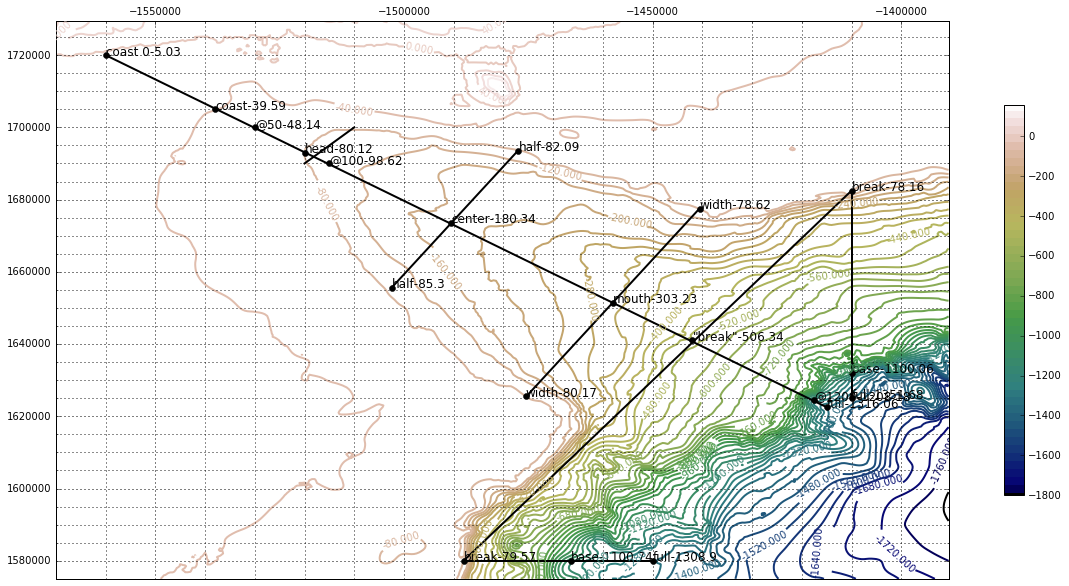

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
xl=-1570000; xr=-1390000; yb=1575000; yt=1730000
xn, yn, zn = return_boundariesS(x, y, z, xl, xr, yb, yt, None)
fig, ax = plot_mackenzie(fig, ax, xn, yn, zn, 'contour', 50)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=1.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.9)

# slope - left
ax.plot([-1488000, -1450000], [1580000, 1580000], 'k', linewidth=2)
bkL = [-1488000, 1580000]; fL = [-1450000, 1580000]; bsL = [-1466500, 1580000]
get_information(ax, bkL, 'break') 
get_information(ax, fL, 'full') 
get_information(ax, bsL, 'base') 

# slope - right
ax.plot([-1410000, -1410000], [1682500, 1625000], 'k', linewidth=2)
bkR = [-1410000, 1682500]; fR = [-1410000, 1625000]; bsR = [-1410000, 1632000]
get_information(ax, bkR, 'break') 
get_information(ax, fR, 'full')
get_information(ax, bsR, 'base') 

ax.plot([bkR[0], bkL[0]], [bkR[1], bkL[1]], 'k', linewidth=2)
bkC = [-1442000, 1641000]
get_information(ax, bkC, '"break"')

# axis from mouth to coast
ax.plot([-1560000, -1415000], [1720000, 1622500], 'k', linewidth=2)
cst0 = [-1560000, 1720000]; cC = [-1490500, 1673500]
fC = [-1415000, 1622500]; cst = [-1538000, 1705000]; hC = [-1520000, 1693000]; mC = [-1458000, 1651500]
get_information(ax, cst0, 'coast 0') 
get_information(ax, fC, 'full')
get_information(ax, cst, 'coast') 
get_information(ax, hC, 'head')
get_information(ax, mC, 'mouth')
get_information(ax, cC, 'center')

# along canyon
m_pend = -1/((1695000-1651500)/(-1523000+1458000)) # ? to mouth
x1 = cC[0]; y1 = cC[1]; x2 = -1477000; y2 = y1 + (m_pend * (x2 - x1))
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2); w2R = [x2, 1693500]
get_information(ax, w2R, 'half')

x2 = -1502500; y2 = y1 + (m_pend * (x2 - x1))
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2); w2L = [x2, 1655500]
get_information(ax, w2L, 'half')

x1 = mC[0]; y1 = mC[1]; x2 = -1440500; y2 = y1 + (m_pend * (x2 - x1))
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2); w1R = [x2, 1677500]
get_information(ax, w1R, 'width')

x2 = -1475500; y2 = y1 + (m_pend * (x2 - x1))
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2); w1L = [x2, 1625500]
get_information(ax, w1L, 'width')

# specific isobaths
at50 = [-1530000, 1700000]
get_information(ax, at50, '@50') 

at100 = [-1515000, 1690000]
get_information(ax, at100, '@100')

at1200 = [-1417500, 1624500]
get_information(ax, at1200, '@1200')

# head
hL = [-1520000, 1690000]
hR = [-1510000, 1700000]
ax.plot([hL[0], hR[0]], [hL[1], hR[1]], 'k', linewidth=2);

base_left = find_distance(fL, bsL)
base_right = find_distance(fR, bsR)
break_left = find_distance(fL, bkL)
break_right = find_distance(fR, bkR)
coast = find_distance(fC, cst)
mouth = find_distance(fC, mC)
length = find_distance(mC, hC)
width_f = find_distance(w1R, w1L)
width_2 = find_distance(w2R, w2L)
width_h = find_distance(hR, hL)
wally = find_distance(fC, cst0)
Rcurv = find_distance(mC, cC)
bath50 = find_distance(fC, at50)
bath100 = find_distance(fC, at100)
length_new_dist = find_distance(bkC, hC)
length_new = find_distance(fC, bkC)


print(base_left,base_right,break_left,break_right,coast,mouth,length,width_f,width_2,width_h,wally,Rcurv,
      length_new_dist, length_new)

#ax.plot(list_x, list_y, c='r')

### Depth Profiles

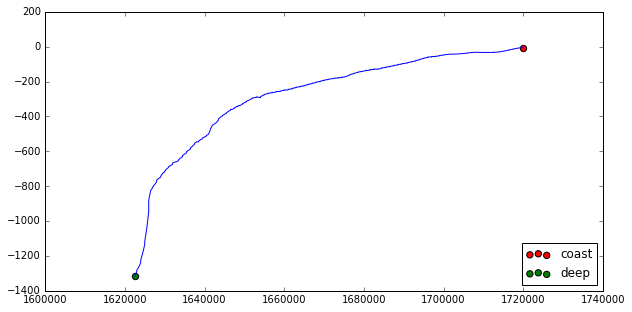

In [7]:
x1 = cst0[0]
y1 = cst0[1]
x2 = fC[0]
y2 = fC[1]

z1 = z[np.where(y==y1), np.where(x==x1)][0][0]
z2 = z[np.where(y==y2), np.where(x==x2)][0][0]

canyon_slope = (y2 - y1) / (x2 - x1)

list_x = np.arange(x1, x2 + 500, 500)
list_y = np.zeros_like(list_x)
list_y[:] = (canyon_slope * (list_x[:] - x1)) + y1
list_y[:] = np.round(list_y[:]/500.0)*500.0
list_z = np.zeros_like(list_x)
for i in np.arange(len(list_x)):
    list_z[i] = z[np.where(y==list_y[i]), np.where(x==list_x[i])][0][0]

fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax.plot(list_y, list_z)
ax.scatter(y1, z1, label='coast', c='r', s=40); ax.scatter(y2, z2, label='deep', c='g', s=40); ax.legend(loc=4)

### Coordinates

In [8]:
# Size of idealized canyon domain (make_mackenzie.ipynb)
w_break = 62682.0
x_wall = 4 * w_break
y_wall = 174732.0
x_wall, x_wall/2, y_wall

(250728.0, 125364.0, 174732.0)

In [14]:
# Size of real domain bounded by these coordinates
lat1 = 69.1; lat2 = 70.7; lon1 = -141.7; lon2 = -134.9
approx_axis = np.mean([-138.1, -138.45])
test_line = 69.8
g = Geod(ellps='clrk66')
az12,az21,distL = g.inv(lon1,lat2,approx_axis,lat2)
az12,az21,distR = g.inv(approx_axis,lat2,lon2,lat2)
az12,az21,distV = g.inv(lon1,lat1,lon1,lat2)
az12,az21,dist_test = g.inv(approx_axis,lat2,approx_axis,test_line)

distL, distR, distV, dist_test

(126381.20288034533, 124536.70059627965, 178503.36072547, 100412.18935358764)

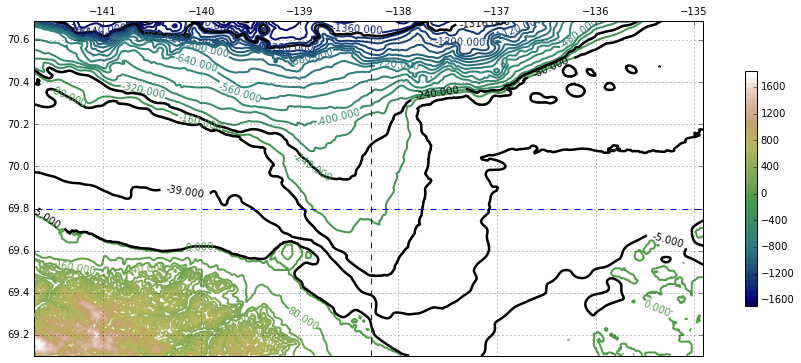

In [16]:
x, y, z = get_variables('IBCAO_V3_30arcsec_RR.grd')
xn, yn, zn = return_boundariesG(x, y, z, lon1, lon2, lat1, lat2, None)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig, ax = plot_mackenzie(fig, ax, xn, yn, zn, 'contour', 50)
ax.grid()
ax.axvline(approx_axis, linestyle='--')
CS = ax.contour(xn, yn, zn, levels = [-1316, -240, -80, -39, -5], colors=('k',),linestyles=('-',),linewidths=(2.5,))
ax.clabel(CS, inline=1, fontsize=10)
ax.axhline(test_line, linestyle='--')